# Frozen Lake

In [1]:
import random
import numpy as np
import time
from FrozenLake import FrozenLake
import matplotlib.pyplot as plt

pygame 2.1.3.dev8 (SDL 2.0.22, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Useful Functions

In [2]:
def action_to_symbol(action):
    if action == 0:
        flecha =  '→'
    elif action == 1:
        flecha = '↓'
    elif action == 2:
        flecha = '←'
    elif action == 3:
        flecha = '↑'
    else:
        flecha = ''

    return flecha

def actions_to_string(actions):
    arrows = [action_to_symbol(a) for a in actions]
    return ' '.join(arrows)

In [3]:
env = FrozenLake('human')

env.reset()

for i in range(50):
    action = env.action_space.sample()
    print('{:3} {}'.format(i+1, action_to_symbol(action)))
    obs, _ , terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        print('The game ended at step {}'.format(i+1))
        break

env.close()

  1 ↓
The game ended at step 1


In [4]:
def try_game(env, policy):

    s, _ = env.reset()

    for i in range(50):
        action = policy[s]
        print('{:3} {}'.format(i+1, action_to_symbol(action)))
        s, _ , terminated, *_ = env.step(action)
        if terminated:
            print('The game ended at step {}'.format(i + 1))
            break
    env.close()

In [5]:
def print_policy(env, policy):

    # POLICY
    print_p = ""
    for state in range(0, env.Ns) :
        if state % env.size == 0:
            print_p += "\n"
        if state == env.goal_state:
            print_p += ' x '
        elif state in env.terminal_states:
            print_p += ' o '
        elif policy[state] == 0:
            print_p += ' → '
        elif policy[state] == 1:
            print_p += ' ↓ '
        elif policy[state] == 2:
            print_p += ' ← '
        else:
            print_p += ' ↑ '
    print(print_p)

# IMPLEMENTATION

### Q-learning MDP

In [6]:
def choose_action_MDP(values, epsilon):
    if random.random() < epsilon:
        # exploration
        return random.choice(range(len(values)))
    else:
        # explotation
        v = np.argwhere(values == np.amax(values)).flatten()
        if len(v) > 0:
            return random.choice(v)
        else:
            return random.choice(range(len(values)))

In [47]:
def QMDP_learning(env, num_episodes=1000, num_steps=100, alpha=0.05, gamma=0.99, eps_max = 1, eps_min = 0.05, chunk_size=1000):

    Q = np.zeros((env.Ns, env.Na))
    best_score_total = num_steps
    best_actions_total = []

    best_score_chunk = num_steps
    best_actions_chunk = []

    epsilon = eps_max
    eps_step = (eps_max - eps_min) / num_episodes

    scores = []
    step_time = []

    print('        BestEver Best   Mean    % Solved  epsilon')

    t0 = time.time_ns()
    s0 = 0 # count steps

    for episode in range(num_episodes):

        score = 0
        actions = []

        s, _ = env.reset()

        new_state = True

        for step in range(num_steps):
            s0 += 1
            
            a = choose_action_MDP(Q[s], epsilon if not new_state else 1)
            new_state = False
            new_s, reward, terminated, *_ = env.step(a)

            score += reward       
            actions.append(a) 

            Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max(Q[new_s]) - Q[s][a])

            if terminated:
                if new_s == env.goal_state:
                    if step + 1 < best_score_chunk:
                        best_score_chunk = step + 1
                        best_actions_chunk = actions

                        if step + 1 < best_score_total:
                            best_score_total = step + 1
                            best_actions_total = actions
                break
            s = new_s


        scores.append(score)
        epsilon -= eps_step if epsilon > eps_min else 0
        
        if episode % chunk_size == chunk_size-1:
            
            step_time.append(1e-6 * (time.time_ns()-t0) / s0)
            t0 = time.time_ns()
            s0 = 0

            if episode < chunk_size:
                to_analyze = scores
            else:
                to_analyze = scores[-chunk_size-1:-1]     
            
            found = sum(1 for i in to_analyze if i > -num_steps ) / len(to_analyze)
            print('Chunk {:>3}: {:>3} | {:>3} | {:>7.2f} | {:>5.1f}% |  {:.4f}  '.format(episode // chunk_size + 1, best_score_total, best_score_chunk,
                                                                                    np.mean(to_analyze), found * 100, epsilon), actions_to_string(best_actions_chunk))
            
            best_score_chunk = num_steps
            best_actions_chunk = []

    return Q, scores, step_time, best_actions_total

### Q-learning LMDP

In [8]:
def choose_action_LMDP(Q):
    if np.sum(Q) == 0:
        Q = np.ones_like(Q)
    p = Q / np.sum(Q)

    return np.random.choice(len(p), 1, p=p)[0]

In [46]:
def QLMDP_learning(env, num_episodes=10000, num_steps=100, alpha=0.1, eta = 1, chunk_size=1000):

    Q = np.ones((env.Ns, env.Na))
    best_score_total = num_steps
    best_actions_total = []

    best_score_chunk = num_steps
    best_actions_chunk = []

    scores = []
    step_time = []

    print('        BestEver Best   Mean    % Solved')

    t0 = time.time_ns()
    s0 = 0 # count steps

    for episode in range(num_episodes):
        score = 0
        actions = []

        s, _ = env.reset()

        for step in range(num_steps):
            s0 += 1

            a = choose_action_LMDP(Q[s])
            new_s, reward, terminated, *_ = env.step(a)

            score += reward       
            actions.append(a)

            Q[s][a] = (1 - alpha) * Q[s][a] + alpha / env.Na * np.exp(eta * reward) * np.sum(Q[new_s])

            if terminated:
                if new_s == env.goal_state:
                    if step + 1 < best_score_chunk:
                        best_score_chunk = step + 1
                        best_actions_chunk = actions

                        if step + 1 < best_score_total:
                            best_score_total = step + 1
                            best_actions_total = actions
                break

            s = new_s

        scores.append(score)

        if episode % chunk_size == chunk_size-1:

            step_time.append(1e-6 * (time.time_ns()-t0) / s0)
            t0 = time.time_ns()
            s0 = 0

            if episode < chunk_size:
                to_analyze = scores
            else:
                to_analyze = scores[-chunk_size-1:-1]     
            
            found = sum(1 for i in to_analyze if i > -num_steps ) / len(to_analyze)
            print('Chunk {:>3}: {:>3} | {:>3} | {:>7.2f} | {:>5.1f}%   '.format(episode // chunk_size + 1, best_score_total, best_score_chunk,
                                                                                    np.mean(to_analyze), found * 100), actions_to_string(best_actions_chunk))
            
            best_score_chunk = num_steps
            best_actions_chunk = []

    return Q, scores, step_time, best_actions_total

### Z-learning LMDP

In [10]:
def compute_P(env):
    P = np.zeros((env.Ns, env.Ns))
    for s in env.states:
        for a in env.actions:
            s_ = env.get_deterministic_state(s, a)
            if s_ != -1:
                P[s, s_] = 1
    
    # normalize
    for s in env.states:
        if s not in env.terminal_states:
            P[s] = P[s] / P[s].sum()
    return P

In [45]:
def Z_learning(env, num_episodes=10000, num_steps=100, alpha=0.1, eta=1, chunk_size=1000):

    P = compute_P(env)
    Z = np.ones(env.Ns)

    best_score_total = num_steps
    best_actions_total = []

    best_score_chunk = num_steps
    best_actions_chunk = []

    scores = []
    step_time = []

    print('        BestEver Best   Mean    % Solved')

    t0 = time.time_ns()
    s0 = 0 # count steps

    for episode in range(num_episodes):

        score = 0
        actions = []

        s, _ = env.reset()

        for step in range(num_steps):
            s0 += 1

            new_s = choose_action_LMDP(P[s] * Z)
            a, reward, terminated, *_ = env.step_no_actions(new_s)

            score += reward       
            actions.append(a) 

            Z[s] = (1 - alpha) * Z[s] + alpha * np.exp(eta * reward) * np.sum(Z * P[s])

            if terminated:
                if new_s == env.goal_state:
                    if step + 1 < best_score_chunk:
                        best_score_chunk = step + 1
                        best_actions_chunk = actions

                        if step + 1 < best_score_total:
                            best_score_total = step + 1
                            best_actions_total = actions

                Z[new_s] = np.exp(eta * reward)
                break
                
            s = new_s

        scores.append(score)
        
        if episode % chunk_size == chunk_size-1:

            step_time.append(1e-6 * (time.time_ns()-t0) / s0)
            t0 = time.time_ns()
            s0 = 0

            if episode < chunk_size:
                to_analyze = scores
            else:
                to_analyze = scores[-chunk_size-1:-1]     
            
            found = sum(1 for i in to_analyze if i > -num_steps ) / len(to_analyze)
            print('Chunk {:>3}: {:>3} | {:>3} | {:>7.2f} | {:>5.1f}%   '.format(episode // chunk_size + 1, best_score_total, best_score_chunk,
                                                                                    np.mean(to_analyze), found * 100), actions_to_string(best_actions_chunk))

            best_score_chunk = num_steps
            best_actions_chunk = []

    return Z, scores, step_time, best_actions_total

In [12]:
def get_action_states(env, s1, s2):
    for a in env.actions:
        s = env.get_deterministic_state(s1, a)
        if s == s2:
            return a
    return None

# TRAINING

In [38]:
num_episodes = 20000
num_steps = 50

env = FrozenLake()
env_show = FrozenLake('human')

### Q-learning MDP

In [48]:
Q_MDP, scores_QMDP, times_QMDP, actions_QMDP = QMDP_learning(env, num_episodes=num_episodes, num_steps=num_steps, alpha=0.1)

        BestEver Best   Mean    % Solved  epsilon
Chunk   1:  50 |  50 | -105.06 |   0.0% |  0.9525   
Chunk   2:  14 |  14 | -105.48 |   0.3% |  0.9050   → ↑ ↓ ↓ ↓ ← ↓ ← ↓ → → ↑ ↓ →
Chunk   3:  14 |  14 | -104.80 |   0.8% |  0.8575   ↑ → → ← ↓ ↓ ← ↓ ↓ ↓ ↓ → → →
Chunk   4:   8 |   8 | -104.00 |   1.7% |  0.8100   → ↓ ↓ ↓ → ↓ ↓ →
Chunk   5:   8 |   9 | -103.48 |   2.6% |  0.7625   ← → ↓ ↓ ↓ → ↓ ↓ →
Chunk   6:   8 |   9 | -102.17 |   4.1% |  0.7150   ↑ → ↓ ↓ ↓ → ↓ ↓ →
Chunk   7:   8 |   8 |  -98.75 |   7.7% |  0.6675   → ↓ ↓ ↓ → ↓ ↓ →
Chunk   8:   8 |   8 |  -98.98 |   6.9% |  0.6200   → ↓ ↓ ↓ → ↓ ↓ →
Chunk   9:   8 |   8 |  -94.39 |  11.8% |  0.5725   → ↓ ↓ ↓ → ↓ ↓ →
Chunk  10:   8 |   8 |  -91.11 |  15.3% |  0.5250   → ↓ ↓ ↓ → ↓ ↓ →
Chunk  11:   8 |   8 |  -89.77 |  16.6% |  0.4775   → ↓ ↓ ↓ → ↓ ↓ →
Chunk  12:   8 |   8 |  -84.26 |  22.0% |  0.4300   → ↓ ↓ ↓ → ↓ ↓ →
Chunk  13:   8 |   8 |  -79.00 |  27.4% |  0.3825   → ↓ ↓ ↓ → ↓ ↓ →
Chunk  14:   8 |   8 |  -75.64 |  30.4% |  0.3350   →

In [15]:
policy_QMDP = np.argmax(Q_MDP, axis=1)
try_game(env_show, policy_QMDP)

  1 →
  2 ↓
  3 ↓
  4 ↓
  5 →
  6 ↓
  7 ↓
  8 →
The game ended at step 8


In [16]:
print_policy(env, policy_QMDP)


 →  ↓  →  ↓  o  ↓ 
 o  ↓  →  ↓  ←  ↓ 
 →  ↓  o  ↓  ↓  ↓ 
 →  →  ↓  ←  ←  ↓ 
 ↓  o  ↓  o  o  ↓ 
 →  →  →  x  ←  ← 


### Q-learning LMDP

In [53]:
Q_LMDP, scores_QLMDP, times_QLMDP, actions_QLMDP = QLMDP_learning(env, num_episodes=num_episodes, num_steps=num_steps)

        BestEver Best   Mean    % Solved
Chunk   1:   8 |   8 | -106.49 |   3.3%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   2:   8 |   8 |  -76.63 |  33.9%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   3:   8 |   8 |  -33.54 |  75.4%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   4:   8 |   8 |  -19.73 |  88.6%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   5:   8 |   8 |  -13.97 |  94.1%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   6:   8 |   8 |  -12.84 |  95.2%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   7:   8 |   8 |  -12.17 |  95.8%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   8:   8 |   8 |  -11.02 |  96.9%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   9:   8 |   8 |   -9.92 |  98.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  10:   8 |   8 |   -9.92 |  98.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  11:   8 |   8 |  -10.04 |  97.9%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  12:   8 |   8 |   -9.65 |  98.3%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  13:   8 |   8 |   -8.73 |  99.2%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  14:   8 |   8 |   -9.84 |  98.1%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  15:   8 |   8 |   -9.44 |  98.5%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  16:   8 |   8 |   -8.35 |  99.6%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  17:   8 

In [18]:
policy_QLMDP = np.argmax(Q_LMDP, axis=1)
try_game(env_show, policy_QLMDP)

  1 →
  2 ↓
  3 ↓
  4 ↓
  5 →
  6 ↓
  7 ↓
  8 →
The game ended at step 8


In [19]:
print_policy(env, policy_QLMDP)


 →  ↓  ↓  ↓  o  → 
 o  ↓  →  ↓  ↓  ↓ 
 ↓  ↓  o  ↓  ↓  ↓ 
 ↓  →  ↓  ←  →  ↓ 
 ↓  o  ↓  o  o  ↓ 
 →  →  →  x  ←  ← 


### Z-learning LMDP

In [54]:
Z_LMDP, scores_ZLMDP, times_ZLMDP, actions_ZLMDP = Z_learning(env, num_episodes=num_episodes, num_steps=num_steps)

        BestEver Best   Mean    % Solved
Chunk   1:   8 |   8 |  -11.49 |  98.1%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   2:   8 |   8 |   -8.16 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   3:   8 |   8 |   -8.14 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   4:   8 |   8 |   -8.19 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   5:   8 |   8 |   -8.10 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   6:   8 |   8 |   -8.13 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   7:   8 |   8 |   -8.15 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   8:   8 |   8 |   -8.10 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk   9:   8 |   8 |   -8.12 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  10:   8 |   8 |   -8.07 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  11:   8 |   8 |   -8.05 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  12:   8 |   8 |   -8.16 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  13:   8 |   8 |   -8.10 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  14:   8 |   8 |   -7.97 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  15:   8 |   8 |   -7.96 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  16:   8 |   8 |   -8.14 | 100.0%    → ↓ ↓ ↓ → ↓ ↓ →
Chunk  17:   8 

In [21]:
P = compute_P(env)
policy_next_states = np.argmax(Z_LMDP * P, axis=1)
policy = [get_action_states(env, s, s_) for s, s_ in zip(env.states, policy_next_states)]
try_game(env_show, policy)

  1 →
  2 ↓
  3 ↓
  4 ↓
  5 →
  6 ↓
  7 ↓
  8 →
The game ended at step 8


# COMPARISSON

### Plots

In [55]:
compare_scores = {'Q MDP': scores_QMDP,  'Q LMDP': scores_QLMDP, 'Z LMDP': scores_ZLMDP}
compare_times = {'Q MDP': times_QMDP,  'Q LMDP': times_QLMDP, 'Z LMDP': times_ZLMDP}

In [63]:
def compare_mean_scores(data, chunk_size, N=10):

    for name, data in data.items():
        groups = [data[x:min(x+chunk_size, len(data)-1)] for x in range(0, len(data), chunk_size)]
        averages = [np.mean(x) for x in groups]
        smooth = np.convolve(averages, np.ones(N)/N, mode='valid')

        plt.plot(np.arange(0, len(data) - (N-1)*chunk_size, chunk_size), smooth, label=name)

    plt.title('Mean Scores over Training')
    plt.suptitle('Frozen Lake')
    plt.legend()
    plt.ylabel('Scores')
    plt.xlabel('Episodes')
    plt.show()

def compare_step_time(data):
    f, ax = plt.subplots(figsize=(5, 6))
    ax.boxplot(list(data.values()), labels=list(data.keys()), flierprops={'marker': 'o', 'markersize': 0.2})

    plt.ylabel('Time in miliseconds')
    plt.title('Step Time over Training')
    plt.suptitle('Frozen Lake')
    plt.show()

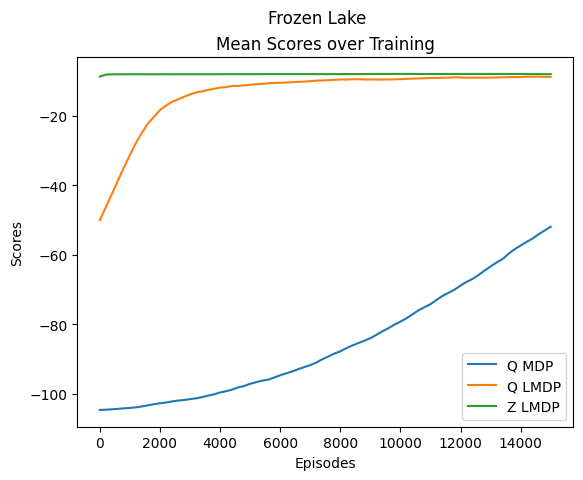

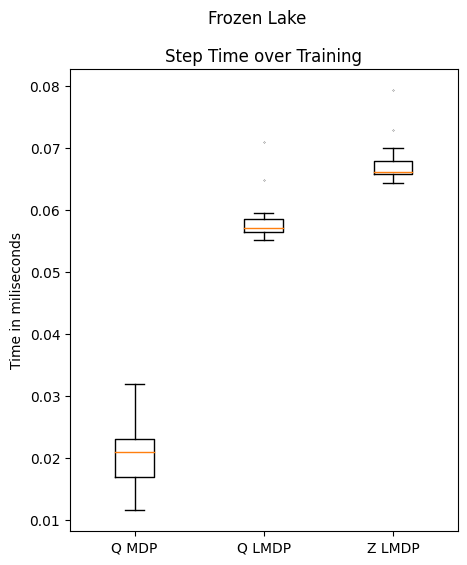

In [64]:
compare_mean_scores(compare_scores, 200, N=25)
compare_step_time(compare_times)